In [1]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from model import RiceClassifier
from data import RiceDataset, get_transform
import torch
import numpy as np
from pathlib import Path
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load dataset

In [2]:
classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
classes_dict = {i: cls for i, cls in enumerate(classes)}

In [3]:
def load_val_dataset(input_dir=Path('../../data/Rice_Image_Dataset/'), val_ratio=0.2, num_workers=6, batch_size=16):
    dataset = RiceDataset(input_dir, transform=get_transform())
    val_amount = int(val_ratio * len(dataset))
    train_amount = len(dataset) - val_amount
    _, val_dataset = torch.utils.data.random_split(dataset, (train_amount, val_amount),
                                                   generator=torch.Generator().manual_seed(42))
    
    val_loader = torch.utils.data.DataLoader(val_dataset, num_workers=num_workers, batch_size=batch_size,
                                             drop_last=False)
    return val_dataset, val_loader

In [4]:
dataset, dataloader = load_val_dataset()

## ResNet

In [5]:
RESNET_WEIGHTS_PATH = 'inference/resnet.pt'

In [6]:
model = RiceClassifier('resnet18')
model.load_state_dict(torch.load(RESNET_WEIGHTS_PATH))

<All keys matched successfully>

In [7]:
model.eval();

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
model.to(device);

In [10]:
preds_list = []
targets_list = []
for imgs, targets in tqdm(dataloader):
    with torch.no_grad():
        imgs = imgs.to(device)
        targets = targets.to(device)
        preds = model.forward(imgs)
        preds = torch.argmax(preds, -1)
        preds = preds.cpu().numpy()
        targets = targets.cpu().numpy()
        preds_list.append(preds)
        targets_list.append(targets)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 104.55it/s]


In [11]:
y_preds = np.concatenate(preds_list)
y_true = np.concatenate(targets_list)

In [12]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3015
           1       1.00      1.00      1.00      2968
           2       1.00      1.00      1.00      2980
           3       1.00      1.00      1.00      3064
           4       1.00      1.00      1.00      2973

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [13]:
(y_preds == y_true).mean()

0.9984666666666666

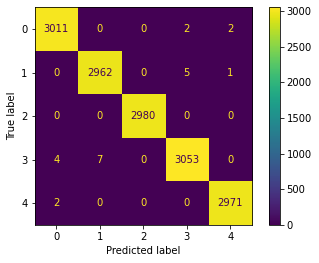

In [14]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [15]:
def transform():
    trans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.], std = [1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.])])
    
    return trans

trans = transform()

In [16]:
indices = np.where(y_true != y_preds)[0]
indices

array([  456,   899,  1485,  1822,  2626,  2958,  3287,  3699,  3739,
        4406,  4850,  4857,  5008,  6386,  7355,  8122,  8866,  9443,
       11475, 11829, 13795, 14438, 14831])

In [17]:
def plot_wrong(indices, preds, ncols, nrows):
    fig = plt.figure(figsize=(8 * ncols, 8 * nrows), dpi=90)
    gridspec = fig.add_gridspec(ncols=ncols, nrows=nrows)
    for i, idx in enumerate(indices):
        img, gt_cls = dataset[idx]
        img = trans(dataset[idx][0]).numpy().transpose((1, 2, 0))
        row = i // ncols
        col = i % ncols
        if row >= nrows:
            break
        ax = fig.add_subplot(gridspec[i:i+1])
        ax.title.set_text(f'TRUE: {classes_dict[gt_cls]}  |  PREDICTED: {classes_dict[preds[idx]]}')
        ax.imshow(img)
        plt.sca(ax)

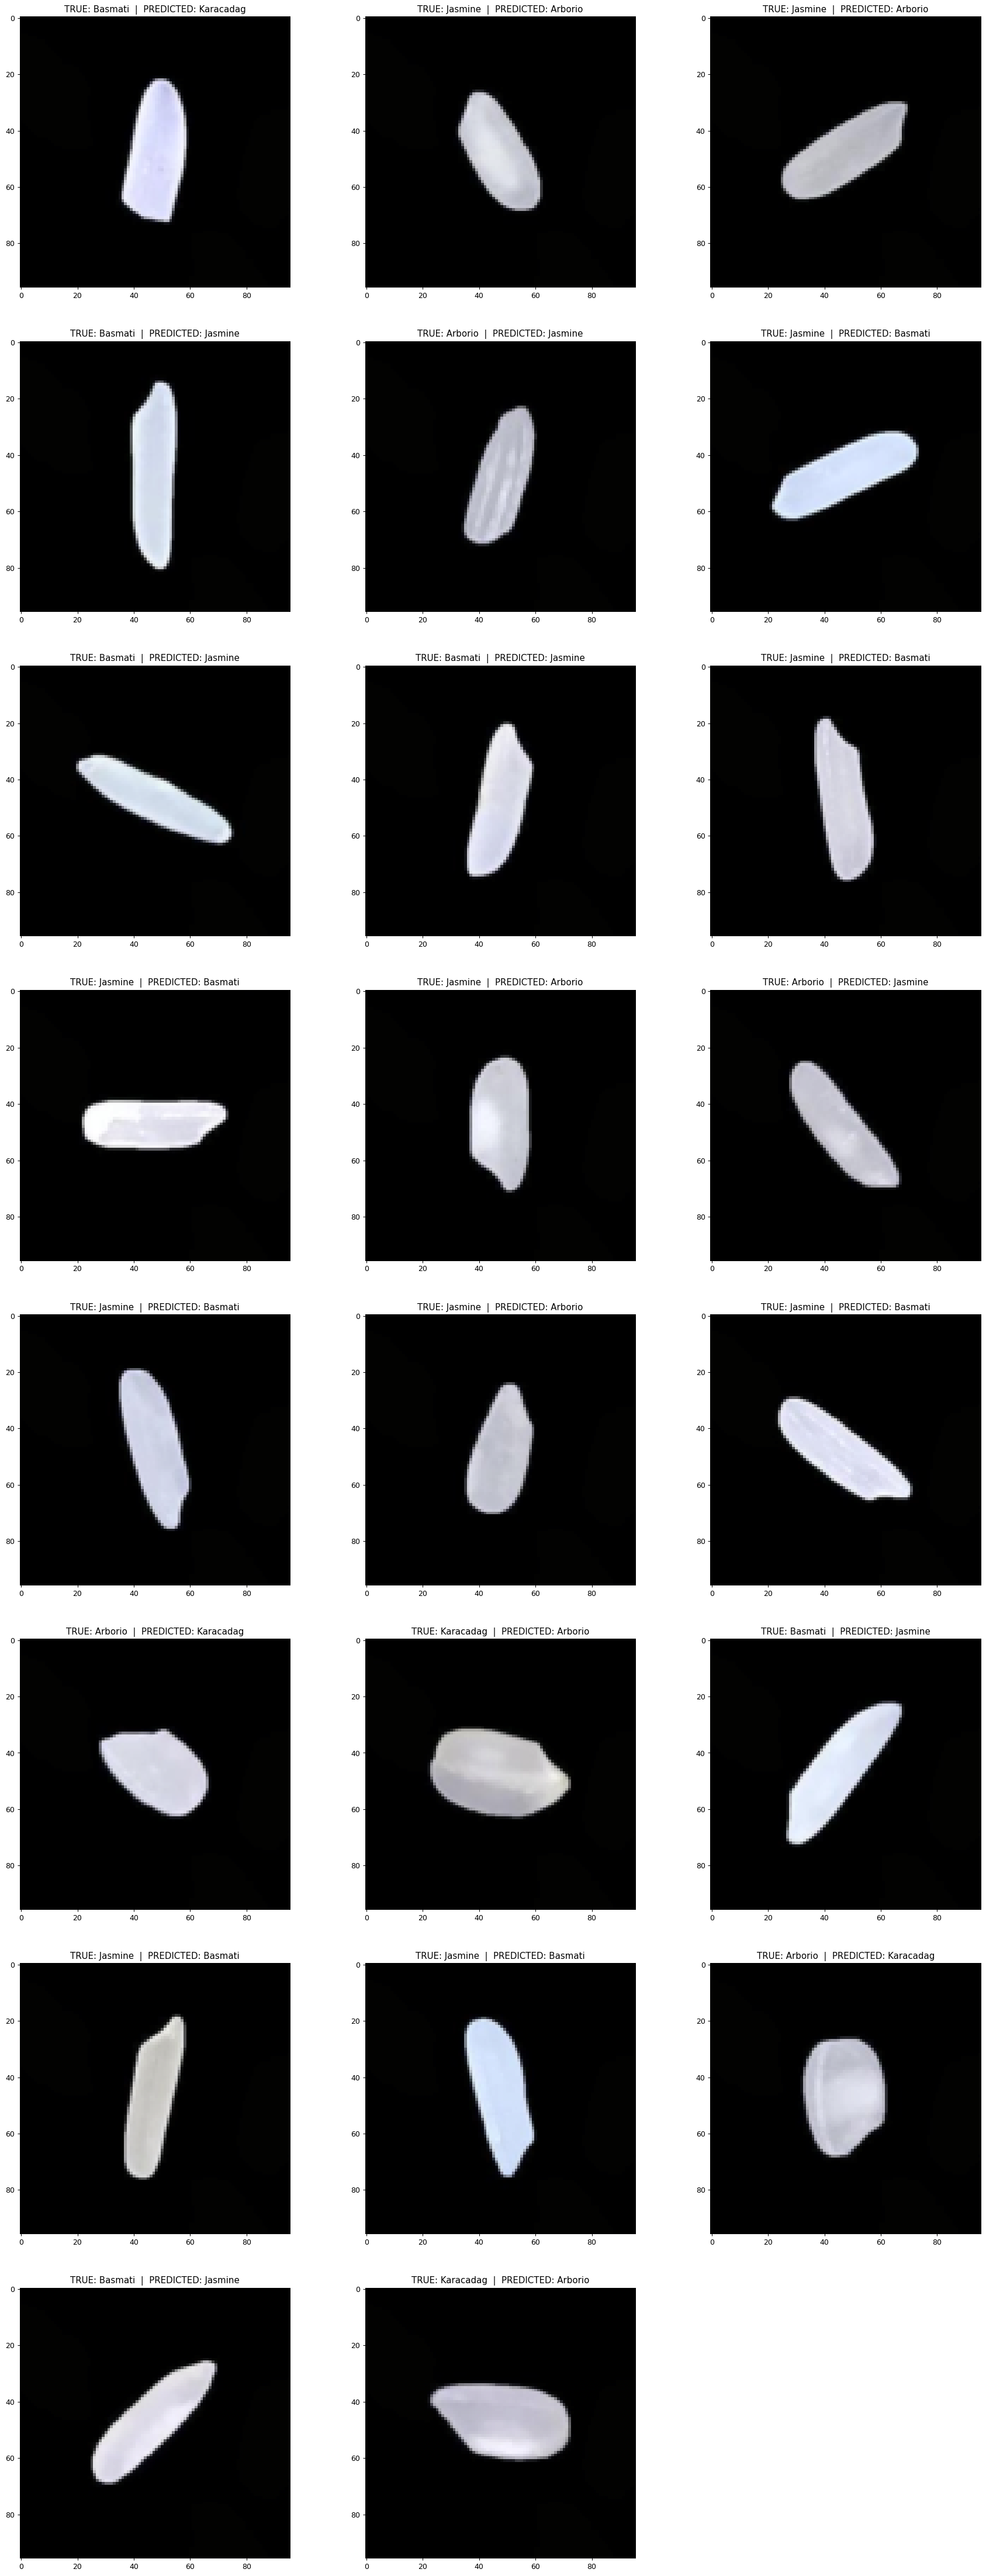

In [18]:
plot_wrong(indices, y_preds, 3, 8)

## EfficientNet

In [19]:
EFFICIENT_WEIGHTS_PATH = 'inference_efficientnet/efficientnet.pt'

In [20]:
model = RiceClassifier('efficientnet_b0')
model.load_state_dict(torch.load(EFFICIENT_WEIGHTS_PATH))

<All keys matched successfully>

In [21]:
model.eval();

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
model.to(device);

In [24]:
preds_list = []
targets_list = []
for imgs, targets in tqdm(dataloader):
    with torch.no_grad():
        imgs = imgs.to(device)
        targets = targets.to(device)
        preds = model.forward(imgs)
        preds = torch.argmax(preds, -1)
        preds = preds.cpu().numpy()
        targets = targets.cpu().numpy()
        preds_list.append(preds)
        targets_list.append(targets)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:09<00:00, 95.58it/s]


In [25]:
y_preds = np.concatenate(preds_list)
y_true = np.concatenate(targets_list)

In [26]:
print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3015
           1       1.00      1.00      1.00      2968
           2       1.00      1.00      1.00      2980
           3       1.00      1.00      1.00      3064
           4       1.00      1.00      1.00      2973

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000



In [27]:
(y_preds == y_true).mean()

0.9989333333333333

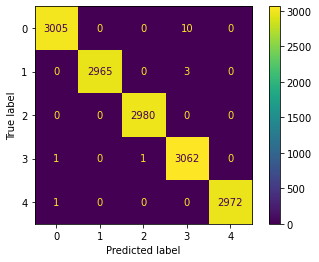

In [28]:
cm = confusion_matrix(y_true, y_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [29]:
indices = np.where(y_true != y_preds)[0]
indices

array([ 962, 2626, 3065, 3287, 3614, 3699, 4257, 4749, 4835, 4850, 4857,
       5028, 5873, 8363, 9443, 9573])

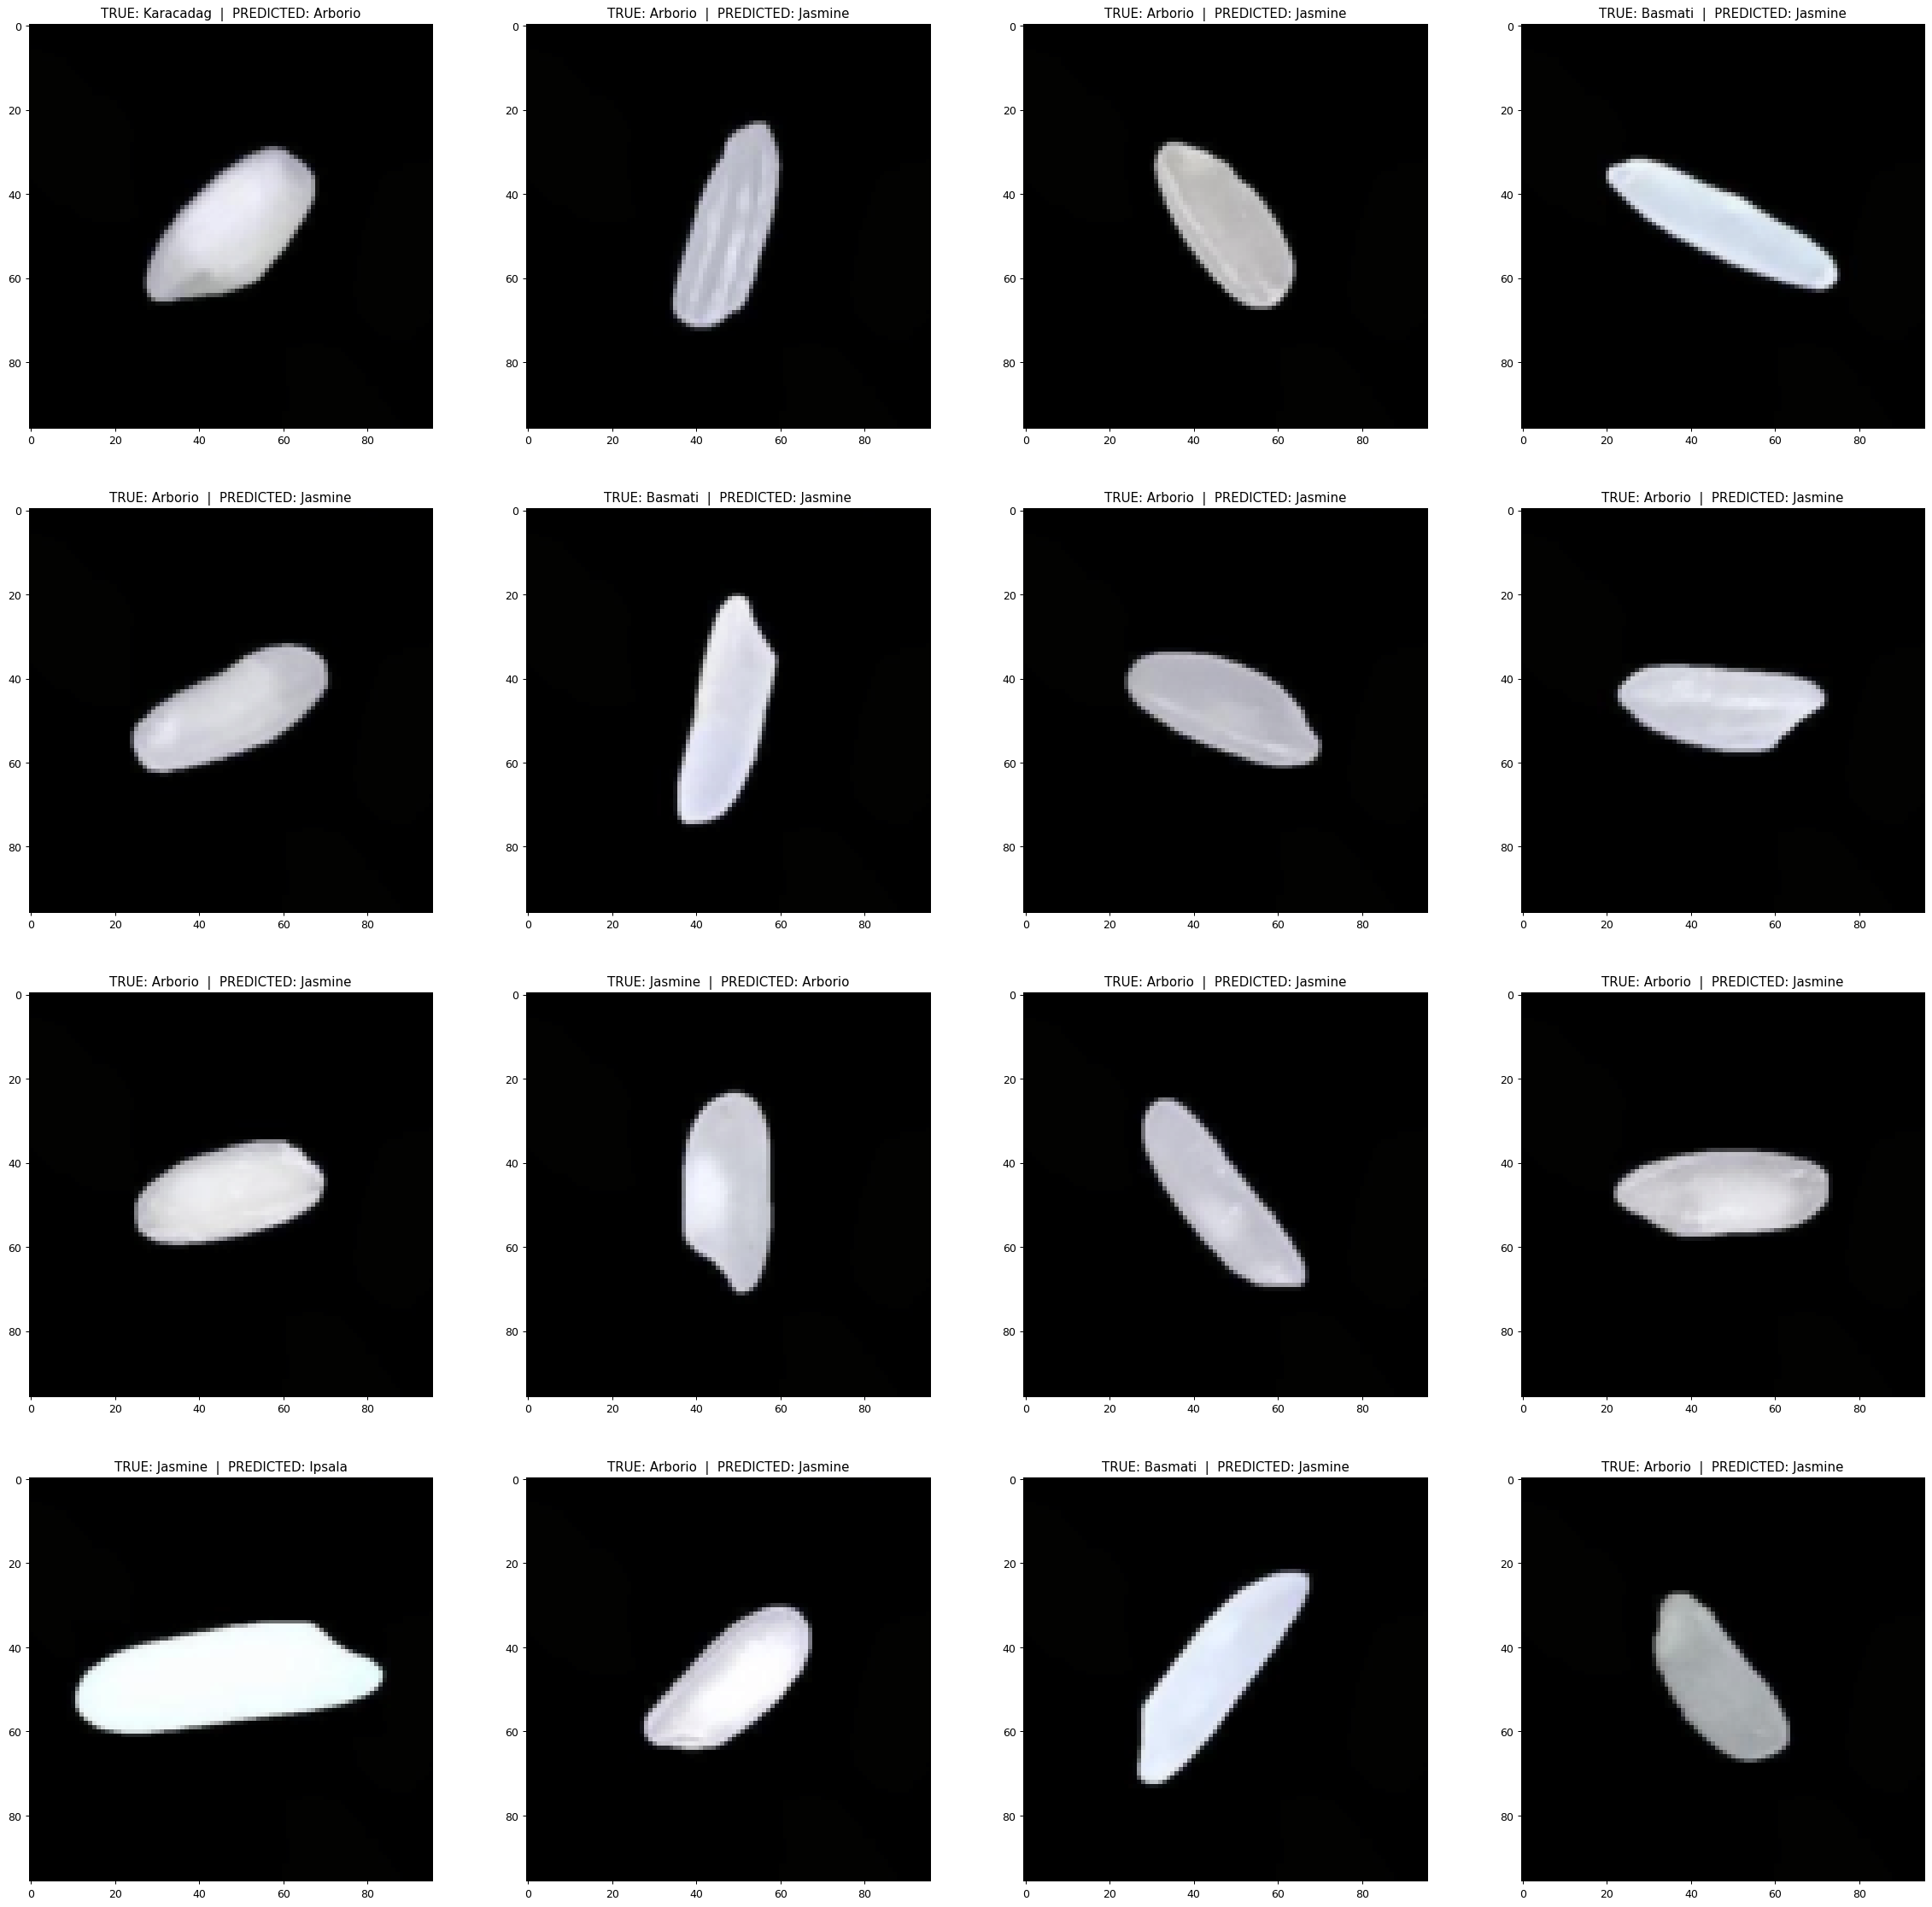

In [30]:
plot_wrong(indices, y_preds, 4, 4)